In [114]:
#import dependencies
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np

# chisom
import hvplot.pandas
import requests
import warnings

from sklearn import datasets
# from datetime import date
import datetime as dt

# store filepaths into variable
results_csv = pd.read_csv('Resources/results.csv', na_values=r'\N')
lap_times_csv = pd.read_csv('Resources/lap_times.csv', na_values=r'\N')
races_csv = pd.read_csv('Resources/races.csv', na_values=r'\N')
constructors_csv = pd.read_csv('Resources/constructors.csv', na_values=r'\N')
constructor_results = pd.read_csv('Resources/constructor_results.csv', na_values=r'\N')
constructor_standings = pd.read_csv('Resources/constructor_standings.csv', na_values=r'\N')
drivers_csv = pd.read_csv('Resources/drivers.csv', na_values=r'\N')
drivers_standings_csv = pd.read_csv('Resources/driver_standings.csv', na_values=r'\N')
circuits_csv = pd.read_csv('Resources/circuits.csv', na_values=r'\N')
pit_stop = pd.read_csv('Resources/pit_stops.csv', na_values=r'\N')

In [115]:
#merge constructor results and constructor standings csv
constructor_df = pd.merge(constructor_results, constructor_standings, how="inner")
constructor_df


,constructorResultsId,raceId,constructorId,points,status,constructorStandingsId,position,positionText,wins
0,1,18,1,14.0,NaN,1,1,1,1
1,2,18,2,8.0,NaN,2,3,3,0
2,3,18,3,9.0,NaN,3,2,2,0
3,4,18,4,5.0,NaN,4,4,4,0
4,5,18,5,2.0,NaN,5,5,5,0
...,...,...,...,...,...,...,...,...,...
3796,16685,1099,210,1.0,NaN,28441,7,7,0
3797,16686,1099,213,0.0,NaN,28440,9,9,0
3798,16688,1099,1,0.0,NaN,28442,10,10,0
3799,16693,1100,1,12.0,NaN,28452,5,5,0


In [116]:
#merge the combined construtors with the constructors csv
constructor_df = pd.merge(constructor_df, constructors_csv, how="inner")
constructor_df

,constructorResultsId,raceId,constructorId,points,status,constructorStandingsId,position,positionText,wins,constructorRef,name,nationality,url
0,1,18,1,14.0,NaN,1,1,1,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,186,36,1,14.0,D,25734,11,E,0,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
2,374,53,1,10.0,NaN,6319,2,2,0,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
3,574,71,1,4.0,NaN,27947,5,5,0,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
4,762,90,1,1.0,NaN,6142,5,5,0,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,16696,1100,213,1.0,NaN,28450,9,9,0,alphatauri,AlphaTauri,Italian,http://en.wikipedia.org/wiki/Scuderia_AlphaTauri
3797,16237,1052,214,0.0,NaN,27680,8,8,0,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team
3798,16247,1053,214,3.0,NaN,27710,7,7,0,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team
3799,16454,1074,214,8.0,NaN,28137,5,5,0,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team


In [117]:
#drop extra columns and combine the merged constructors with races csv on "raceId"

new_constructor_df_constructor= constructor_df.drop(columns=["status", "positionText", "constructorRef"])
new_constructor_df = pd.merge(constructor_df, races_csv, on="raceId")
new_constructor_df

,constructorResultsId,raceId,constructorId,points,status,constructorStandingsId,position,positionText,wins,constructorRef,...,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,18,1,14.0,NaN,1,1,1,1,mclaren,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,18,2,8.0,NaN,2,3,3,0,bmw_sauber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,18,3,9.0,NaN,3,2,2,0,williams,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,18,4,5.0,NaN,4,4,4,0,renault,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,18,5,2.0,NaN,5,5,5,0,toro_rosso,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,16409,1070,210,0.0,NaN,27892,10,10,0,haas,...,2021-11-05,NaN,2021-11-05,NaN,2021-11-06,NaN,2021-11-06,NaN,NaN,NaN
3797,16419,1071,210,0.0,NaN,27902,10,10,0,haas,...,2021-11-12,NaN,2021-11-13,NaN,NaN,NaN,2021-11-12,NaN,2021-11-13,NaN
3798,16428,1051,210,0.0,NaN,27912,10,10,0,haas,...,2021-11-19,NaN,2021-11-19,NaN,2021-11-20,NaN,2021-11-20,NaN,NaN,NaN
3799,16439,1072,210,0.0,NaN,27922,10,10,0,haas,...,2021-12-03,NaN,2021-12-03,NaN,2021-12-04,NaN,2021-12-04,NaN,NaN,NaN


In [118]:
#dropping extra columns again after last merge
clean_construtors= new_constructor_df.drop(columns=["fp1_date", "fp1_time", "fp2_date",	"fp2_time", "fp3_date", "fp3_time","quali_date","quali_time","sprint_date", "sprint_time","date","time", "url_x", "url_y", "status","positionText"])
clean_construtors

,constructorResultsId,raceId,constructorId,points,constructorStandingsId,position,wins,constructorRef,name_x,nationality,year,round,circuitId,name_y
0,1,18,1,14.0,1,1,1,mclaren,McLaren,British,2008,1,1,Australian Grand Prix
1,2,18,2,8.0,2,3,0,bmw_sauber,BMW Sauber,German,2008,1,1,Australian Grand Prix
2,3,18,3,9.0,3,2,0,williams,Williams,British,2008,1,1,Australian Grand Prix
3,4,18,4,5.0,4,4,0,renault,Renault,French,2008,1,1,Australian Grand Prix
4,5,18,5,2.0,5,5,0,toro_rosso,Toro Rosso,Italian,2008,1,1,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,16409,1070,210,0.0,27892,10,0,haas,Haas F1 Team,American,2021,18,32,Mexico City Grand Prix
3797,16419,1071,210,0.0,27902,10,0,haas,Haas F1 Team,American,2021,19,18,São Paulo Grand Prix
3798,16428,1051,210,0.0,27912,10,0,haas,Haas F1 Team,American,2021,20,78,Qatar Grand Prix
3799,16439,1072,210,0.0,27922,10,0,haas,Haas F1 Team,American,2021,21,77,Saudi Arabian Grand Prix


In [119]:
#rename columns
clean_construtors = clean_construtors.rename(columns={"name_x":"constructor_name", "name_y":"circuit name"})
clean_construtors

,constructorResultsId,raceId,constructorId,points,constructorStandingsId,position,wins,constructorRef,constructor_name,nationality,year,round,circuitId,circuit name
0,1,18,1,14.0,1,1,1,mclaren,McLaren,British,2008,1,1,Australian Grand Prix
1,2,18,2,8.0,2,3,0,bmw_sauber,BMW Sauber,German,2008,1,1,Australian Grand Prix
2,3,18,3,9.0,3,2,0,williams,Williams,British,2008,1,1,Australian Grand Prix
3,4,18,4,5.0,4,4,0,renault,Renault,French,2008,1,1,Australian Grand Prix
4,5,18,5,2.0,5,5,0,toro_rosso,Toro Rosso,Italian,2008,1,1,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,16409,1070,210,0.0,27892,10,0,haas,Haas F1 Team,American,2021,18,32,Mexico City Grand Prix
3797,16419,1071,210,0.0,27902,10,0,haas,Haas F1 Team,American,2021,19,18,São Paulo Grand Prix
3798,16428,1051,210,0.0,27912,10,0,haas,Haas F1 Team,American,2021,20,78,Qatar Grand Prix
3799,16439,1072,210,0.0,27922,10,0,haas,Haas F1 Team,American,2021,21,77,Saudi Arabian Grand Prix


In [120]:
#find winning constructors from 2004

constructors_after_2004 = clean_construtors[(clean_construtors["year"]) >=2004]
constructors_after_2004 = constructors_after_2004.sort_values("year", ascending=True)
constructors_after_2004

,constructorResultsId,raceId,constructorId,points,constructorStandingsId,position,wins,constructorRef,constructor_name,nationality,year,round,circuitId,circuit name
45,766,90,17,0.0,6146,9,0,jordan,Jordan,Irish,2004,1,1,Australian Grand Prix
44,761,90,16,3.0,6141,4,0,bar,BAR,British,2004,1,1,Australian Grand Prix
43,763,90,15,0.0,6143,6,0,sauber,Sauber,Swiss,2004,1,1,Australian Grand Prix
42,765,90,7,0.0,6145,8,0,toyota,Toyota,Japanese,2004,1,1,Australian Grand Prix
41,758,90,6,18.0,6138,1,1,ferrari,Ferrari,Italian,2004,1,1,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,16686,1099,213,0.0,28440,9,0,alphatauri,AlphaTauri,Italian,2023,2,77,Saudi Arabian Grand Prix
687,16693,1100,1,12.0,28452,5,0,mclaren,McLaren,British,2023,3,1,Australian Grand Prix
688,16696,1100,213,1.0,28450,9,0,alphatauri,AlphaTauri,Italian,2023,3,1,Australian Grand Prix
674,16679,1098,1,0.0,28492,10,0,mclaren,McLaren,British,2023,1,3,Bahrain Grand Prix


In [121]:
top_winning_constructors = constructors_after_2004[constructors_after_2004["position"]==1].groupby(["constructorId", "constructor_name","nationality"])
top_winning_constructors.head()

,constructorResultsId,raceId,constructorId,points,constructorStandingsId,position,wins,constructorRef,constructor_name,nationality,year,round,circuitId,circuit name
41,758,90,6,18.0,6138,1,1,ferrari,Ferrari,Italian,2004,1,1,Australian Grand Prix
30,570,71,4,16.0,27943,1,1,renault,Renault,French,2005,1,1,Australian Grand Prix
20,372,53,4,10.0,6317,1,1,renault,Renault,French,2006,1,3,Bahrain Grand Prix
11,185,36,6,13.0,25733,1,1,ferrari,Ferrari,Italian,2007,1,1,Australian Grand Prix
0,1,18,1,14.0,1,1,1,mclaren,McLaren,British,2008,1,1,Australian Grand Prix
702,3823,1,23,18.0,4038,1,1,brawn,Brawn,British,2009,1,1,Australian Grand Prix
507,13900,337,6,43.0,24232,1,1,ferrari,Ferrari,Italian,2010,1,3,Bahrain Grand Prix
520,14129,841,9,35.0,24660,1,1,red_bull,Red Bull,Austrian,2011,1,1,Australian Grand Prix
525,14356,860,1,40.0,24932,1,1,mclaren,McLaren,British,2012,1,1,Australian Grand Prix
539,14597,880,6,30.0,25136,1,0,ferrari,Ferrari,Italian,2013,1,1,Australian Grand Prix


In [122]:
#calculate win counts for each year 
win_counts = top_winning_constructors['wins'].sum().reset_index()
win_counts.value_counts()


constructorId  constructor_name  nationality  wins
1              McLaren           British      2       1
4              Renault           French       2       1
6              Ferrari           Italian      6       1
9              Red Bull          Austrian     2       1
23             Brawn             British      1       1
131            Mercedes          German       5       1
dtype: int64

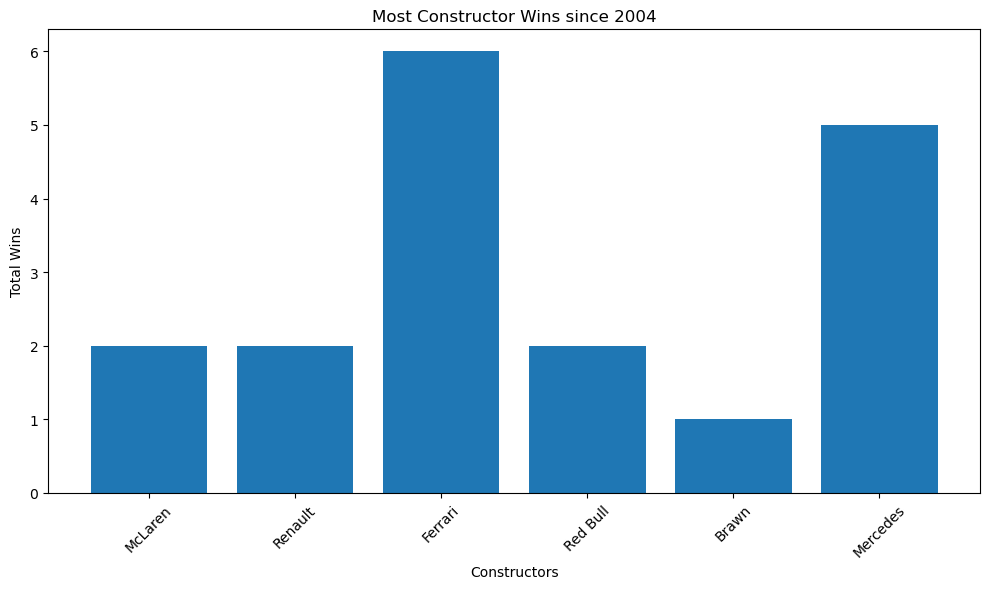

In [123]:
# Create a bar chart for top constructors per year from 2004
plt.figure(figsize=(10, 6))
plt.bar(win_counts['constructor_name'], win_counts['wins'])
plt.xlabel('Constructors')
plt.ylabel('Total Wins')
plt.title('Most Constructor Wins since 2004')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the chart
plt.show()

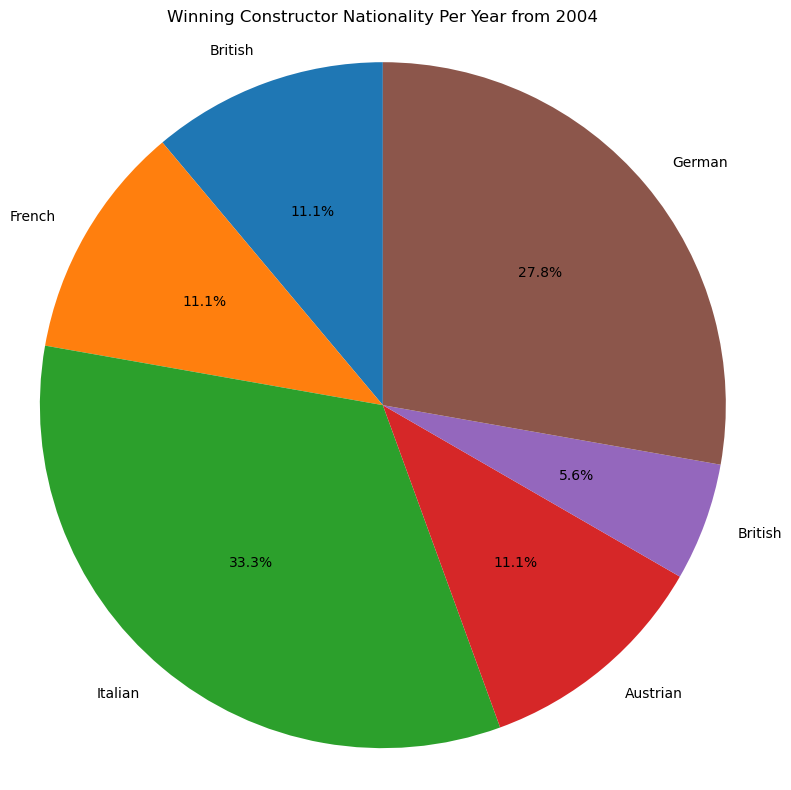

In [124]:
# Create a pie chart for top constructors per year based on nationality
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(win_counts['wins'], labels=win_counts['nationality'], autopct='%1.1f%%', startangle=90)

ax.set_title('Winning Constructor Nationality Per Year from 2004')

plt.axis('equal')  

plt.tight_layout()
plt.show()

In [125]:
#based on the data, the top 3 most successful constructors are Ferrari, Redbull and Mercedes. Ferarri has been the most successful constructor for f1 in the last 20 years. There can be many factors: such as investment of resources, technical innovation and talent recruitment. Italian made cars serve as a blueprint for success for team managers starting a team in F1. 

In [126]:
races_df=pd.DataFrame(races_csv, columns=[
                        "year", "raceId", "date"])
races_df

,year,raceId,date
0,2009,1,2009-03-29
1,2009,2,2009-04-05
2,2009,3,2009-04-19
3,2009,4,2009-04-26
4,2009,5,2009-05-10
...,...,...,...
1096,2023,1116,2023-10-22
1097,2023,1117,2023-10-29
1098,2023,1118,2023-11-05
1099,2023,1119,2023-11-19


In [127]:
results_df=pd.DataFrame(results_csv, columns=[
                        "raceId", "driverId"])
results_df

,raceId,driverId
0,18,1
1,18,2
2,18,3
3,18,4
4,18,5
...,...,...
26075,1110,817
26076,1110,858
26077,1110,807
26078,1110,832


In [128]:
drivers_df=pd.DataFrame(drivers_csv, columns=[
                        "dob", "driverRef", "driverId"])
drivers_df

,dob,driverRef,driverId
0,1985-01-07,hamilton,1
1,1977-05-10,heidfeld,2
2,1985-06-27,rosberg,3
3,1981-07-29,alonso,4
4,1981-10-19,kovalainen,5
...,...,...,...
852,1999-03-22,mick_schumacher,854
853,1999-05-30,zhou,855
854,1995-02-06,de_vries,856
855,2001-04-06,piastri,857


In [129]:
drivers_standings_df=pd.DataFrame(drivers_standings_csv, columns=[
                        "wins", "driverId", "raceId"])
drivers_standings_df

,wins,driverId,raceId
0,1,1,18
1,0,2,18
2,0,3,18
3,0,4,18
4,0,5,18
...,...,...,...
34119,0,846,1110
34120,0,839,1110
34121,0,844,1110
34122,0,857,1110


In [130]:
driver_merged=pd.merge(drivers_df, drivers_standings_df,  on="driverId")

In [131]:
driver_merged=pd.merge(drivers_df, drivers_standings_df,  on="driverId")
driver_merged_clean= driver_merged.dropna()
driver_merged_clean.head()

,dob,driverRef,driverId,wins,raceId
0,1985-01-07,hamilton,1,1,18
1,1985-01-07,hamilton,1,1,19
2,1985-01-07,hamilton,1,1,20
3,1985-01-07,hamilton,1,1,21
4,1985-01-07,hamilton,1,1,22


In [132]:
driver_merged_clean=pd.merge(driver_merged_clean, races_df, on="raceId")
driver_merged_clean


,dob,driverRef,driverId,wins,raceId,year,date
0,1985-01-07,hamilton,1,1,18,2008,2008-03-16
1,1977-05-10,heidfeld,2,0,18,2008,2008-03-16
2,1985-06-27,rosberg,3,0,18,2008,2008-03-16
3,1981-07-29,alonso,4,0,18,2008,2008-03-16
4,1981-10-19,kovalainen,5,0,18,2008,2008-03-16
...,...,...,...,...,...,...,...
34119,1898-06-09,fagioli,786,0,833,1950,1950-05-13
34120,1906-07-06,harrison,787,0,833,1950,1950-05-13
34121,1915-10-26,fry,788,0,833,1950,1950-05-13
34122,1915-03-24,martin,789,0,833,1950,1950-05-13


In [133]:
driver_name = driver_merged_clean.set_index('driverRef').groupby(['driverRef'])
driver_name.head()
after_2004_races_df = driver_merged_clean[(driver_merged_clean['date']) > '2004-01-01']
after_2004_races_df= after_2004_races_df.sort_values('year', ascending=True)
after_2004_races_df

,dob,driverRef,driverId,wins,raceId,year,date
9793,1981-01-01,baumgartner,47,0,91,2004,2004-03-21
8104,1975-09-20,montoya,31,0,98,2004,2004-06-20
8105,1983-02-07,klien,32,0,98,2004,2004-06-20
8106,1973-09-19,matta,43,0,98,2004,2004-06-20
8107,1966-09-02,panis,44,0,98,2004,2004-06-20
...,...,...,...,...,...,...,...
6963,1997-09-30,max_verstappen,830,3,1102,2023,2023-05-07
6964,1994-09-01,sainz,832,0,1102,2023,2023-05-07
6965,1996-09-17,ocon,839,0,1102,2023,2023-05-07
6936,1985-01-07,hamilton,1,0,1101,2023,2023-04-30


In [134]:
after_2004_races_df.count()

dob          8411
driverRef    8411
driverId     8411
wins         8411
raceId       8411
year         8411
date         8411
dtype: int64

In [135]:
after_2004_races_df["dob"] = pd.to_datetime(after_2004_races_df["dob"])

# Extract the year from the date of birth
after_2004_races_df["dob_year"] = after_2004_races_df["dob"].dt.year

# Calculate the age at the time of the race in years
after_2004_races_df["age"] = after_2004_races_df["year"] - after_2004_races_df["dob_year"]

# Drop the temporary 'dob_year' column if you no longer need it
after_2004_races_df = after_2004_races_df.drop(columns=["dob_year"])
after_2004_races_df

,dob,driverRef,driverId,wins,raceId,year,date,age
9793,1981-01-01,baumgartner,47,0,91,2004,2004-03-21,23
8104,1975-09-20,montoya,31,0,98,2004,2004-06-20,29
8105,1983-02-07,klien,32,0,98,2004,2004-06-20,21
8106,1973-09-19,matta,43,0,98,2004,2004-06-20,31
8107,1966-09-02,panis,44,0,98,2004,2004-06-20,38
...,...,...,...,...,...,...,...,...
6963,1997-09-30,max_verstappen,830,3,1102,2023,2023-05-07,26
6964,1994-09-01,sainz,832,0,1102,2023,2023-05-07,29
6965,1996-09-17,ocon,839,0,1102,2023,2023-05-07,27
6936,1985-01-07,hamilton,1,0,1101,2023,2023-04-30,38


In [136]:
reduce_driver_merged_group = after_2004_races_df[(after_2004_races_df["age"] < 60)]
reduce_driver_merged_group .head()

#explain why 60 was the cut off mark


,dob,driverRef,driverId,wins,raceId,year,date,age
9793,1981-01-01,baumgartner,47,0,91,2004,2004-03-21,23
8104,1975-09-20,montoya,31,0,98,2004,2004-06-20,29
8105,1983-02-07,klien,32,0,98,2004,2004-06-20,21
8106,1973-09-19,matta,43,0,98,2004,2004-06-20,31
8107,1966-09-02,panis,44,0,98,2004,2004-06-20,38


The cut off mark for the age was based on the retirement age in the united states, most career focused job have s retirment age bewteen 50-65 years and i believe having a cut off age at 60 was a good benchamrk 

In [137]:
reduce_driver_merged_group.count()

dob          8411
driverRef    8411
driverId     8411
wins         8411
raceId       8411
year         8411
date         8411
age          8411
dtype: int64

In [138]:
driver_merged_group2=reduce_driver_merged_group.groupby(["wins"]).max()
driver_merged_group2.tail()

,dob,driverRef,driverId,raceId,year,date,age
wins,,,,,,,
11,1997-09-30,vettel,830,1091,2022,2022-10-02,35
12,1997-09-30,vettel,830,1092,2022,2022-10-09,35
13,1997-09-30,vettel,830,1093,2022,2022-10-23,35
14,1997-09-30,max_verstappen,830,1095,2022,2022-11-13,25
15,1997-09-30,max_verstappen,830,1096,2022,2022-11-20,25


In [139]:
driver_merged_group2_aver=reduce_driver_merged_group['age'].mean()
driver_merged_group2_aver
#this result shows that the average age bewteen all drivers regardless of the amount of wins is 28 years old 

28.055879205801926

In [140]:
driver_merged_group2_avera=reduce_driver_merged_group['wins'].mean()
driver_merged_group2_avera

0.4528593508500773

In [141]:
age_group= reduce_driver_merged_group.groupby(["age"])
age_group.head()


,dob,driverRef,driverId,wins,raceId,year,date,age
9793,1981-01-01,baumgartner,47,0,91,2004,2004-03-21,23
8104,1975-09-20,montoya,31,0,98,2004,2004-06-20,29
8105,1983-02-07,klien,32,0,98,2004,2004-06-20,21
8106,1973-09-19,matta,43,0,98,2004,2004-06-20,31
8107,1966-09-02,panis,44,0,98,2004,2004-06-20,38
...,...,...,...,...,...,...,...,...
3700,1997-09-30,max_verstappen,830,0,939,2015,2015-09-20,18
3722,1997-09-30,max_verstappen,830,0,940,2015,2015-09-27,18
3658,1997-09-30,max_verstappen,830,0,937,2015,2015-08-23,18
3679,1997-09-30,max_verstappen,830,0,938,2015,2015-09-06,18


In [142]:
top4_wins=reduce_driver_merged_group.loc[reduce_driver_merged_group['wins']>=10]
top4_wins
#explain why you use 12 as a benchmark
#Looking at the top 4 winners, i needed a benchmark to see what age the drivers won. Looking at 10 wins seem the more reasonable because the most wins should be drivers that have double digts wins, with the amount of race held yearly and the amount ciructs done during the year.

,dob,driverRef,driverId,wins,raceId,year,date,age
8168,1969-01-03,michael_schumacher,30,11,101,2004,2004-07-25,35
8146,1969-01-03,michael_schumacher,30,10,100,2004,2004-07-11,35
8287,1969-01-03,michael_schumacher,30,13,106,2004,2004-10-10,35
8312,1969-01-03,michael_schumacher,30,13,107,2004,2004-10-24,35
8214,1969-01-03,michael_schumacher,30,12,103,2004,2004-08-29,35
8191,1969-01-03,michael_schumacher,30,12,102,2004,2004-08-15,35
8262,1969-01-03,michael_schumacher,30,12,105,2004,2004-09-26,35
8238,1969-01-03,michael_schumacher,30,12,104,2004,2004-09-12,35
2054,1987-07-03,vettel,20,11,858,2011,2011-11-13,24
2082,1987-07-03,vettel,20,11,859,2011,2011-11-27,24


Looking at the top 4 winners, i needed a benchmark to see what age the drivers won. Looking at 10 wins seem the more reasonable because the most wins should be drivers that have double digts wins, with the amount of race held yearly and the amount ciructs done during the year.

In [143]:
top4_wins_group= top4_wins.groupby(["driverRef"])
top4_wins_group

In [144]:
top4_wins_aver=top4_wins_group['age'].mean()
top4_wins_aver

driverRef
hamilton              32.222222
max_verstappen        25.000000
michael_schumacher    35.000000
vettel                25.000000
Name: age, dtype: float64

In [145]:
age_groups=reduce_driver_merged_group.groupby(["age"]).max()

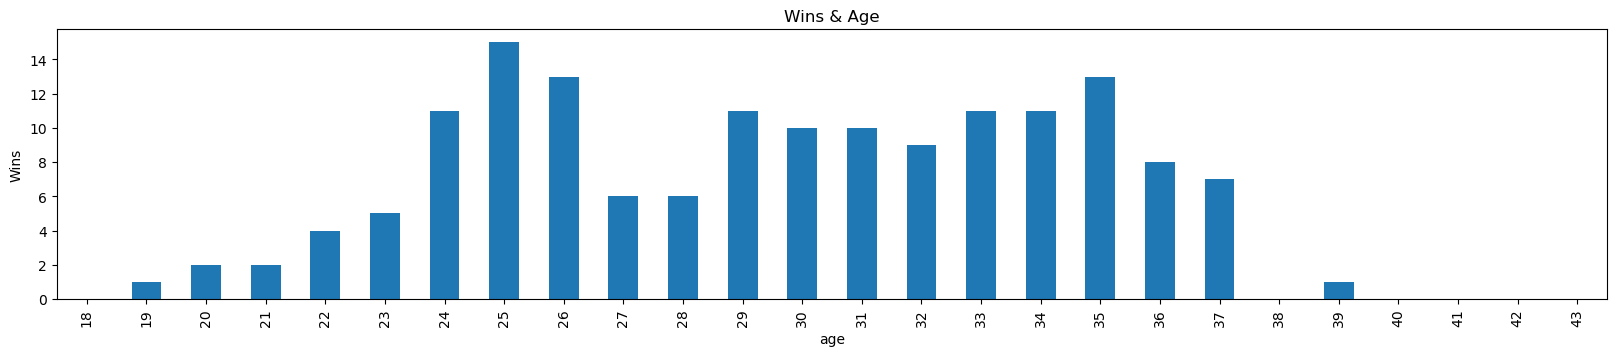

In [146]:
age_of_driver_graph= age_groups['wins']
age_of_driver_graph.plot(kind="bar", figsize=(20,3.5))
plt.xlabel("age")
plt.ylabel("Wins")
plt.title("Wins & Age")
plt.show()

In [147]:
winss= reduce_driver_merged_group['wins']
age = reduce_driver_merged_group['age']
st.pearsonr(reduce_driver_merged_group['age'],reduce_driver_merged_group['wins'])
print(f"The correlation coefficient between wins and age is {round(st.pearsonr(winss, age)[0],2)}")
#explain how there is no correlation between the age and wins 


The correlation coefficient between wins and age is 0.06


The correlation shown proves that there is a signficant but not enough signficance for the age of a driver to be taken into account when looking at the fsctors that play into whether or not a head coach should hire an young driver or someone of an older age.

In [148]:
x_values = reduce_driver_merged_group['age']
y_values = reduce_driver_merged_group['wins']
linregress(x_values, y_values)
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

The r-squared is: 0.003047111200028664


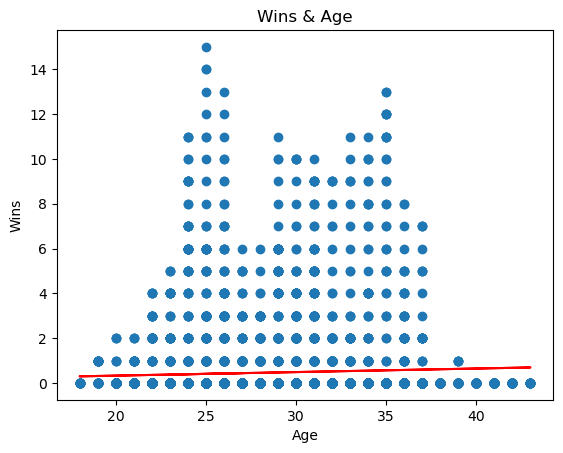

In [149]:
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Age')
plt.ylabel('Wins')
plt.title("Wins & Age")
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [150]:

#merge pit_stops and results
df = pd.merge(pit_stop, results_csv, on=['raceId', 'driverId'], suffixes=('_pit', '_result'), how='inner')
# Convert milliseconds to numeric
df['milliseconds_pit'] = pd.to_numeric(df['milliseconds_pit'], errors='coerce')
df['milliseconds_result'] = pd.to_numeric(df['milliseconds_result'], errors='coerce')
# Convert milliseconds to seconds
df['seconds_pit'] = df['milliseconds_pit'] / 1000
df['seconds_result'] = df['milliseconds_result'] / 1000
# drop the columns that are not needed for the analysis
df.drop(['milliseconds_pit', 'milliseconds_result',  'fastestLap', 'fastestLapSpeed', 'statusId', 'laps', 'lap', 'resultId', 'fastestLapTime', 'fastestLapSpeed', 'statusId','number', 'grid',], axis=1, inplace=True)

print(df.columns)

Index(['raceId', 'driverId', 'stop', 'time_pit', 'duration', 'constructorId',
       'position', 'positionText', 'positionOrder', 'points', 'time_result',
       'rank', 'seconds_pit', 'seconds_result'],
      dtype='object')


## Correlation Analysis:

The correlation between pit stop duration and final race result is approximately 0.08. This value is close to zero, indicating a weak positive correlation. The correlation suggests that there is a slight tendency for longer pit stop durations to be associated with slightly longer race result durations.


The scatter plot illustrates the connection between pit stop duration and race result duration for each constructor. The trend suggests a weak positive correlation, indicating that, on average, teams with shorter pit stops tend to have slightly shorter race result durations.

However, it's important to highlight the dispersion of points across the plot. Despite the overall trend, there is a considerable variation in race result durations even among teams with similar pit stop times. This variance emphasizes that while pit stop efficiency plays a role, it is not the sole factor influencing race outcomes.

In the context of our main research question about the impact of pit stop times on team performance, this scatter plot suggests that a shorter pit stop duration may contribute to a faster race result, but it is not a guarantee. Teams need to consider other factors, such as overall race strategy and driver performance, to achieve consistent success in the highly competitive F1 environment.

In [151]:
# Drop rows with missing values in either pit stop or result duration
df_cleaned = df.dropna(subset=['seconds_pit', 'seconds_result'])

# Calculate correlation
correlation = df_cleaned['seconds_pit'].corr(df_cleaned['seconds_result'])

print(f"Correlation between pit stop duration and final race result: {correlation}")

Correlation between pit stop duration and final race result: 0.33462239711643876


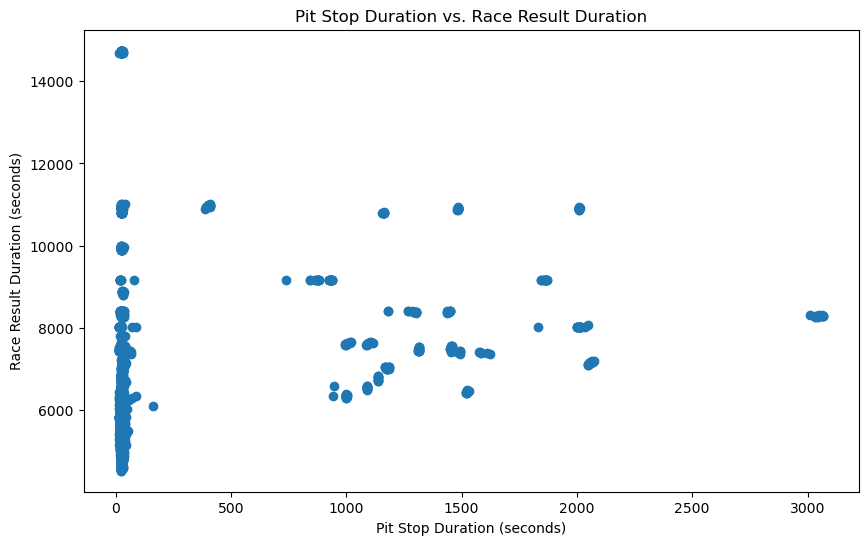

In [152]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['seconds_pit'], df_cleaned['seconds_result'])
plt.title('Pit Stop Duration vs. Race Result Duration')
plt.xlabel('Pit Stop Duration (seconds)')
plt.ylabel('Race Result Duration (seconds)')
plt.show()


## Box Plot - Pit Stop Duration by Constructor:
The box plot visually represents the distribution of pit stop durations for each constructor. The significant differences observed in the ANOVA result indicate that there are variations in pit stop durations among different constructors.
The box plot vividly illustrates the diversity in pit stop durations across constructors. Each box encapsulates the middle 50% of pit stop times, with the median denoted by a black line. The 'whiskers' extend to showcase the range of typical pit stop durations, revealing considerable variability.

Examining the box plot alongside the statistical summary, it becomes evident that different constructors employ distinct pit stop strategies. Constructor 1, for instance, has an average pit stop duration of approximately 81 seconds, while Constructor 5 maintains an average of about 44 seconds. This stark contrast highlights the significant differences in pit stop efficiency among teams.

The statistical summary offers a nuanced view, presenting key metrics like the mean, standard deviation, and quartiles for each constructor. The wide range of pit stop durations emphasizes the strategic diversity employed by different teams.

In the context of our primary research question on the impact of pit stop times on team performance, this analysis underscores a crucial point. The substantial variation in pit stop durations suggests that the efficiency of pit stops significantly differs among constructors. Teams with consistently shorter pit stops may have a competitive edge, influencing their overall race performance and contributing to the broader narrative of what factors contribute to success in Formula 1.


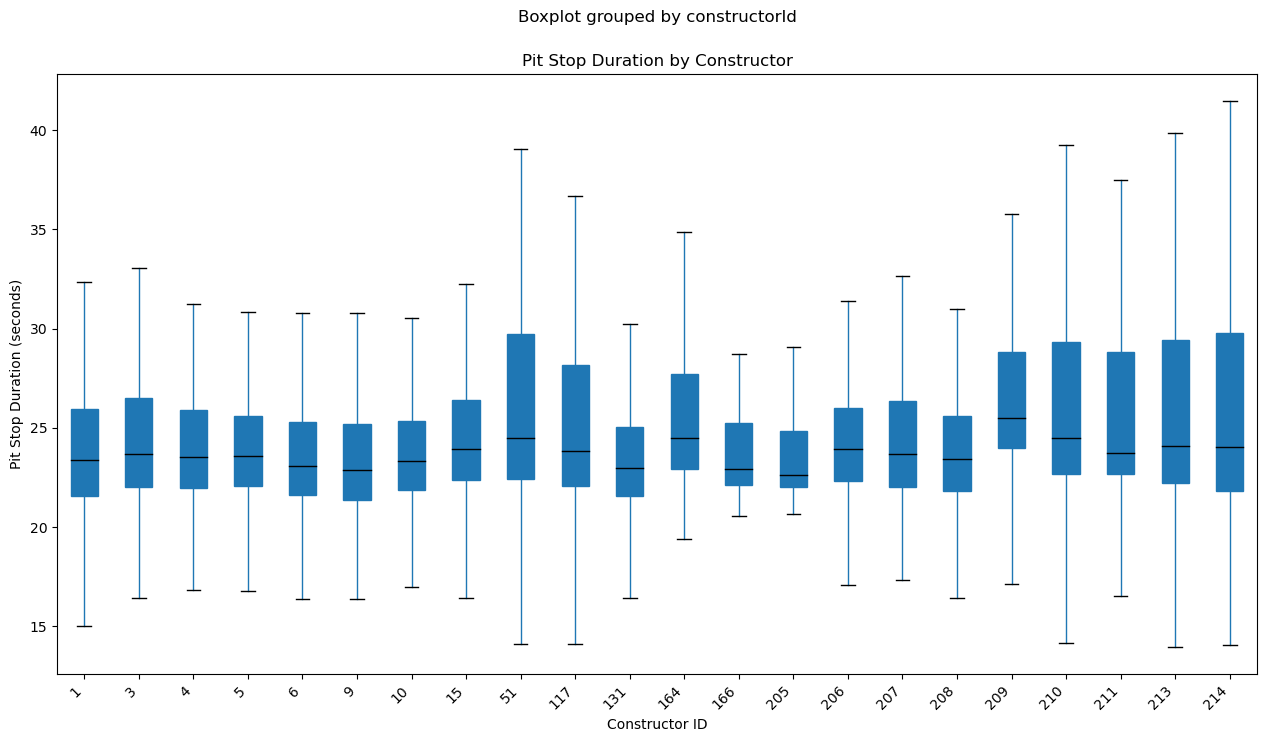

               count        mean         std     min       25%      50%  \
constructorId                                                             
1              962.0   81.189005  299.236653  13.173  21.58000  23.3940   
3              996.0   69.974902  261.158533  12.897  22.04525  23.6975   
4              403.0   63.261834  227.330159  12.959  21.97800  23.5550   
5              683.0   44.486984  167.998979  14.641  22.05800  23.5840   
6              964.0   74.867382  282.949370  13.259  21.64300  23.0755   
9              991.0   73.556724  278.299268  13.335  21.34800  22.8710   
10             609.0   50.845770  192.371854  14.128  21.86900  23.3380   
15             621.0   44.546525  157.872919  13.201  22.39000  23.9550   
51             334.0  142.361805  411.976208  14.128  22.44675  24.5110   
117            202.0  177.105990  494.647526  14.118  22.07225  23.8595   
131            977.0   77.019505  279.084862  13.199  21.57200  22.9860   
164            150.0   32

In [153]:

fig, ax = plt.subplots(figsize=(15, 8))
df.boxplot(column='seconds_pit', by='constructorId', grid=False, showfliers=False, patch_artist=True, medianprops={'color':'black'}, ax=ax)
plt.title('Pit Stop Duration by Constructor')
plt.xlabel('Constructor ID')
plt.ylabel('Pit Stop Duration (seconds)')
plt.xticks(rotation=45, ha='right')
plt.show()

# Statistical Analysis
constructor_pit_duration_stats = df.groupby('constructorId')['seconds_pit'].describe()
print(constructor_pit_duration_stats) 

## ANOVA Result:

The ANOVA test is used to assess whether there are significant differences in pit stop durations among constructors. The low p-value (close to zero) suggests that we reject the null hypothesis, indicating that there are indeed significant differences in pit stop durations among constructors.

In [154]:

# Extract pit stop durations by constructor for ANOVA
pit_durations = [df[df['constructorId'] == constructor]['seconds_pit'].dropna().values for constructor in df['constructorId'].unique()]

# Perform ANOVA
anova_result = st.f_oneway(*pit_durations)

# Display the ANOVA result
print("ANOVA Result:")
print(anova_result)

# Check for statistical significance
alpha = 0.05
if anova_result.pvalue < alpha:
    print("\nReject the null hypothesis. There are significant differences in pit stop durations among constructors.")
else:
    print("\nFail to reject the null hypothesis. There are no significant differences in pit stop durations among constructors.")

ANOVA Result:
F_onewayResult(statistic=7.612729800764962, pvalue=3.7413783135963225e-23)

Reject the null hypothesis. There are significant differences in pit stop durations among constructors.


The analysis employs ANOVA (Analysis of Variance) to investigate whether there are significant differences in pit stop durations among different constructors. The ANOVA result yields a statistically significant p-value of approximately 3.74e-23, well below the commonly used significance level of 0.05.

This low p-value indicates that we can reject the null hypothesis, which posits that there are no differences in pit stop durations among constructors. Therefore, the evidence suggests that there are indeed significant variations in pit stop times across different teams.

The summary statistics for pit stop durations by constructor further support this finding. Examining the mean pit stop durations for each constructor, we observe substantial differences. For instance, Constructor 1 has an average pit stop duration of 81.19 seconds, while Constructor 5 maintains an average of 44.49 seconds. The standard deviations and quartiles highlight the spread and distribution of pit stop durations, emphasizing the diversity in strategies employed by different teams.

In the context of our overarching research question on the impact of pit stop times on team performance, this ANOVA analysis strengthens the narrative. The rejection of the null hypothesis implies that pit stop durations play a significant role in distinguishing team performance. Teams with consistently faster or slower pit stops can influence their overall race outcomes, contributing to the broader understanding of factors influencing success in Formula 1.

The analysis employs ANOVA (Analysis of Variance) to investigate whether there are significant differences in pit stop durations among different constructors. The ANOVA result yields a statistically significant p-value of approximately 3.74e-23, well below the commonly used significance level of 0.05.

This low p-value indicates that we can reject the null hypothesis, which posits that there are no differences in pit stop durations among constructors. Therefore, the evidence suggests that there are indeed significant variations in pit stop times across different teams.

The summary statistics for pit stop durations by constructor further support this finding. Examining the mean pit stop durations for each constructor, we observe substantial differences. For instance, Constructor 1 has an average pit stop duration of 81.19 seconds, while Constructor 5 maintains an average of 44.49 seconds. The standard deviations and quartiles highlight the spread and distribution of pit stop durations, emphasizing the diversity in strategies employed by different teams.

In the context of our overarching research question on the impact of pit stop times on team performance, this ANOVA analysis strengthens the narrative. The rejection of the null hypothesis implies that pit stop durations play a significant role in distinguishing team performance. Teams with consistently faster or slower pit stops can influence their overall race outcomes, contributing to the broader understanding of factors influencing success in Formula 1.

In [ ]:
# yargi trying commit